In [2]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import scienceplots
import os

from sklearn.metrics import mean_squared_error, r2_score
from nanonets.utils import logic_gate_sample, fitness, abundance, abundance_plot, load_boolean_results
from nanonets import Simulation

plt.style.use(["science","bright","grid"])
PATH  = "/home/jonasmensing/bagheera/data/1_funding_period/phase_space_sample/"
PATH2 = "/mnt/c/Users/jonas/Desktop/phd/nanonets/scripts/1_funding_period/surrogate_model/"

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [3]:
def get_transfer_coeff(n):
    topo = {"Nx": n, "Ny": n,
            "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                       [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
            "electrode_type" : ['constant']*8}
    sim_class = Simulation(topology_parameter=topo, pack_optimizer=False)
    sim_class.build_conductance_matrix()
    sim_class.init_transfer_coeffs()
    return sim_class.get_transfer_coeffs()

### LGBM Model

In [4]:
# Model
model_filepath  = os.path.join(PATH2, "final_lgbm_model.txt")
bst             = lgb.Booster(model_file=model_filepath)

# Data
# df              = pd.read_csv(f"{PATH}Nx=9_Ny=9_Ne=8.csv")
# avg_obs         = df['Observable'].abs().mean()

In [5]:
N_PARTICLES = 9
N_E         = 8
V_ON        = 0.01
V_OFF       = 0.0
V_RANGE     = 0.05
INPUT_POS   = [1,3]
SCALE       = False
INPUT_COL   = [f"E{INPUT_POS[0]}",f"E{INPUT_POS[1]}"]
N_SAMPLES   = 10000
TOPO        = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
                "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                [N_PARTICLES-1,int((N_PARTICLES)/2)],
                [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
                "electrode_type" : ['constant']*N_E}

In [6]:
voltages        = logic_gate_sample(V_RANGE, INPUT_POS, N_SAMPLES, TOPO, V_ON, sample_technique='uniform')
if SCALE:
    t_coeff     = get_transfer_coeff(N_PARTICLES)
    factor      = np.ones_like(t_coeff, dtype=float)
    np.divide(t_coeff[INPUT_POS[0]], t_coeff, out=factor, where=t_coeff!=0)
    voltages    *= np.hstack((factor,0.0))
voltages        = voltages[:,:-2]
current_data    = bst.predict(voltages)*1e-9
data            = pd.DataFrame(np.hstack((voltages,current_data[:,np.newaxis],np.zeros(shape=(len(current_data),1)))),
                               columns=([f"E{i}" for i in range(7)]+['Observable','Error'])).round(6)
fitness_data    = fitness(df=data, input_cols=INPUT_COL, off_state=V_OFF, on_state=V_ON, delta=0)
abundance_data  = abundance(fitness_data)

(-6.0, 6.0)

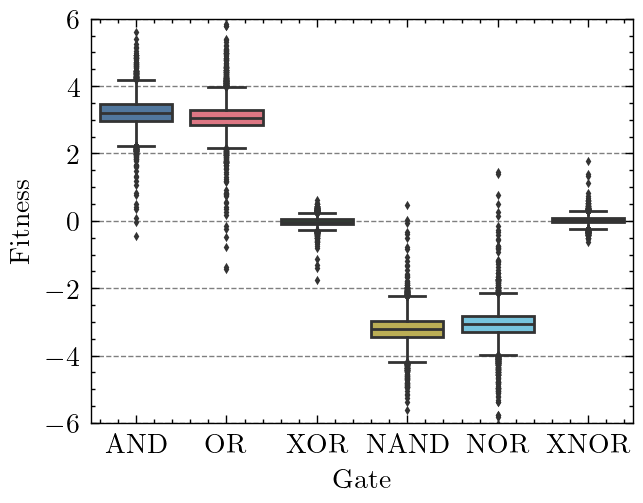

In [7]:
df_box          = fitness_data.loc[:,'AND Fitness':]
df_box.columns  = ["AND", "OR", "XOR", "NAND", "NOR", "XNOR"]
df_box          = df_box.melt(value_name='Fitness', var_name='Gate')

fig, ax = plt.subplots(dpi=200)
ax      = sns.boxplot(df_box, x='Gate', y='Fitness', fliersize=1)
ax.set_ylim(-6,6)

---

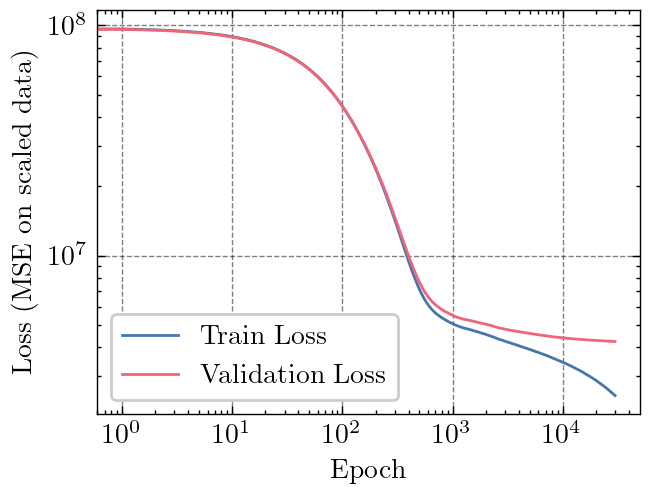

In [60]:
fig, ax = plt.subplots(dpi=200)
ax.plot(history.evals_result_['training']['rmse'], label='Train Loss')
ax.plot(history.evals_result_['valid_1']['rmse'], label='Validation Loss')
ax.set_ylabel('Loss (MSE on scaled data)')
ax.set_xlabel('Epoch')
ax.set_yscale('log')
ax.set_xscale('log')
ax.legend()

In [71]:
y_pred  = final_model.predict(X_test)
mse     = mean_squared_error(y_test, y_pred)
rmse    = np.sqrt(mse)
r2      = r2_score(y_test, y_pred)

print("\nFinal Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"RMSE / AVG(Error): {rmse/np.mean(y_e):.4f}")
print(f"R-squared (R2): {r2:.4f}")


Final Model Evaluation:
Mean Squared Error (MSE): 18009237896394.4844
Root Mean Squared Error (RMSE): 4243729.2440
RMSE / AVG(Error): 1.3982
R-squared (R2): 0.9981


Text(0, 0.5, 'Predicted Values')

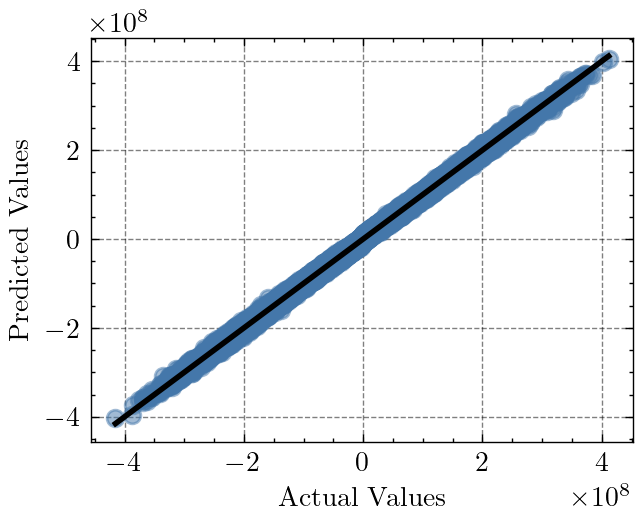

In [72]:
fig, ax = plt.subplots(dpi=200)
ax.scatter(y_test, y_pred, alpha=0.5)
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'black', linewidth=2)
ax.set_xlabel("Actual Values")
ax.set_ylabel("Predicted Values")

In [73]:
feature_names           = [f'$U{i}$' for i in range(X.shape[1])]
importances             = best_model.feature_importances_
feature_importance_df   = pd.DataFrame({'feature': feature_names, 'importance': importances})
feature_importance_df   = feature_importance_df.sort_values(by='importance', ascending=False)

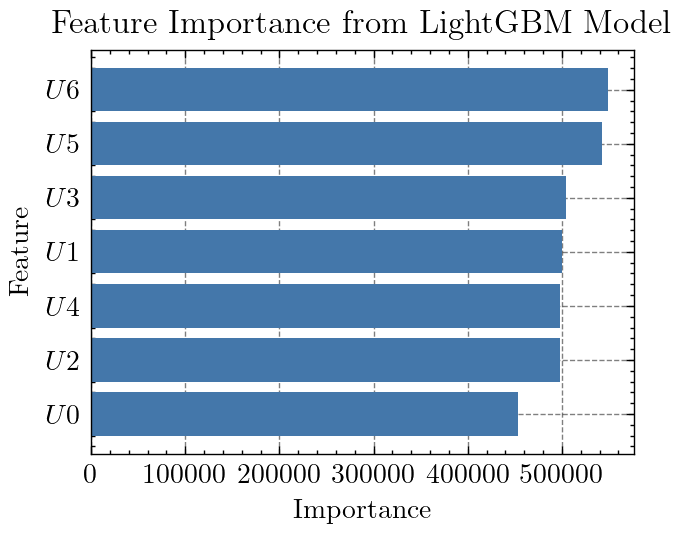

In [74]:
fig, ax = plt.subplots(dpi=200)
ax.barh(feature_importance_df['feature'], feature_importance_df['importance'])
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
ax.set_title('Feature Importance from LightGBM Model')
ax.invert_yaxis()

# Surrogate Model

In [75]:
def get_transfer_coeff(n):
    topo = {"Nx": n, "Ny": n,
            "e_pos" : [[0,0], [int((n-1)/2),0], [n-1,0], [0,int((n-1)/2)],
                       [0,n-1], [n-1,int((n)/2)], [int((n)/2),(n-1)], [n-1,n-1]],
            "electrode_type" : ['constant']*8}
    sim_class = Simulation(topology_parameter=topo, pack_optimizer=False)
    sim_class.build_conductance_matrix()
    sim_class.init_transfer_coeffs()
    return sim_class.get_transfer_coeffs()

In [136]:
N_PARTICLES = 9
N_E         = 8
V_ON        = 0.01
V_OFF       = 0.0
V_RANGE     = 0.05
INPUT_POS   = [1,3]
SCALE       = True
INPUT_COL   = [f"E{INPUT_POS[0]}",f"E{INPUT_POS[1]}"]
N_SAMPLES   = 50000
TOPO        = {"Nx": N_PARTICLES, "Ny": N_PARTICLES,
                "e_pos" : [[0,0], [int((N_PARTICLES-1)/2),0], [N_PARTICLES-1,0],
                [0,int((N_PARTICLES-1)/2)], [0,N_PARTICLES-1],
                [N_PARTICLES-1,int((N_PARTICLES)/2)],
                [int((N_PARTICLES)/2),(N_PARTICLES-1)], [N_PARTICLES-1,N_PARTICLES-1]],
                "electrode_type" : ['constant']*N_E}

In [137]:
voltages        = logic_gate_sample(V_RANGE, INPUT_POS, N_SAMPLES, TOPO, V_ON, sample_technique='uniform')
if SCALE:
    t_coeff     = get_transfer_coeff(N_PARTICLES)
    factor      = np.ones_like(t_coeff, dtype=float)
    np.divide(t_coeff[INPUT_POS[0]], t_coeff, out=factor, where=t_coeff!=0)
    voltages    *= np.hstack((factor,0.0))
voltages        = voltages[:,:-2]
current_data    = best_model.predict(voltages)*1e-9
data            = pd.DataFrame(np.hstack((voltages,current_data[:,np.newaxis],np.zeros(shape=(len(current_data),1)))),
                               columns=([f"E{i}" for i in range(7)]+['Observable','Error'])).round(6)
fitness_data    = fitness(df=data, input_cols=INPUT_COL, off_state=V_OFF, on_state=V_ON, delta=0)
abundance_data  = abundance(fitness_data)

(-6.0, 6.0)

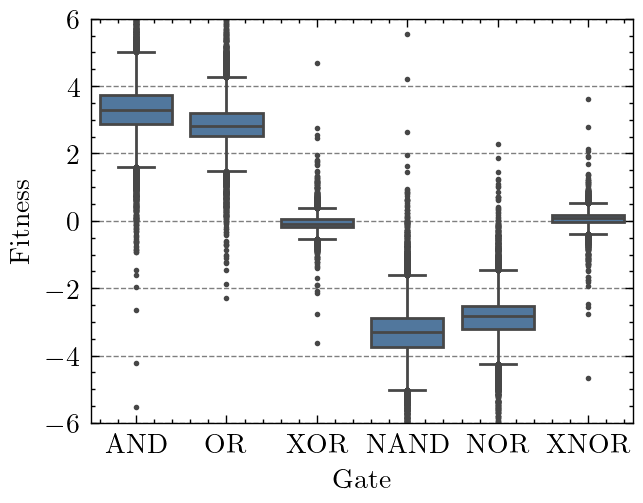

In [138]:
df_box          = fitness_data.loc[:,'AND Fitness':]
df_box.columns  = ["AND", "OR", "XOR", "NAND", "NOR", "XNOR"]
df_box          = df_box.melt(value_name='Fitness', var_name='Gate')

fig, ax = plt.subplots(dpi=200)
ax      = sns.boxplot(df_box, x='Gate', y='Fitness', fliersize=1)
ax.set_ylim(-6,6)

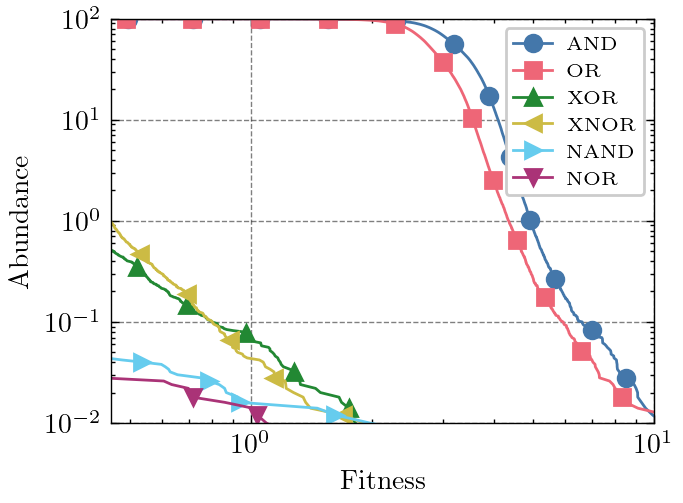

In [140]:
fig, ax = abundance_plot(abundance_data, y_limits=[0.01,100])